# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import cmcrameri.cm
from scipy.stats import entropy
#import xesmf as xe
import regionmask
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
from dask.diagnostics import progress
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'


C:\Users\luisg\AppData\Local\Temp\ipykernel_20500\2730774703.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 19.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56915,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 19.91 GiB
Comm: tcp://127.0.0.1:56955,Total threads: 2
Dashboard: http://127.0.0.1:56956/status,Memory: 4.98 GiB
Nanny: tcp://127.0.0.1:56918,


In [3]:
ibge = gpd.read_file(r'D:\GU\IC\Shapes\AtlasMar_BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
ds_knn = xr.open_dataset(r'Data\knn_cerrado3.nc')
ds_knn.rio.write_crs(shp_cerrado.crs, inplace=True)
regions = gpd.read_file(r'Data\regions1.geojson')
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
palette = sns.color_palette('cmc.batlow', 3)
cerrado_mask = regionmask.Regions([regions.geometry.values[0], regions.geometry.values[1], regions.geometry.values[2]], names=['Central', 'Southern', 'Eastern'], abbrevs=['C', 'S', 'E'], name = 'Cerrado Regions')


# PANGEO Routine

## precipitation

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
523769,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523770,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523771,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523772,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


In [39]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['pr'],
    member_id = 'r1i1p1f1',
    #source_id = ['GFDL-CM4', 'GFDL-ESM4','HadGEM3-GC31-LL', 'CESM2', 'CESM2-WACCM']
    #
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\intake_esm\_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CAS-ESM2-0,3,1,1
CESM2-WACCM,3,1,1
CMCC-CM2-SR5,3,1,1
CMCC-ESM2,3,1,1
CanESM5,3,1,1


In [40]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [41]:
from collections import defaultdict
dsets_ = dask.compute(dict(dsets))[0]


In [42]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)



In [43]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['mask'] = mask

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].groupby('mask').apply(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xarray\core\variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xarray\core\variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chun

In [44]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

2023-04-05 18:47:16,373 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61607', name: 0, status: running, memory: 356, processing: 109>
2023-04-05 18:47:16,493 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61611', name: 3, status: running, memory: 349, processing: 386>
2023-04-05 18:47:16,717 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61607'.
2023-04-05 18:47:16,725 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61611'.
2023-04-05 18:47:37,242 - distributed.nanny - WARNING - Worker process still alive after 3.999983787536621 seconds, killing
2023-04-05 18:47:37,555 - distributed.nanny - WARNING - Worker process still alive after 3.9999893188476565 seconds, killing
2023-04-05 18:47:38,709 - tornado.application - ERROR - Exception in call

In [45]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds['pr'] = big_ds['pr'] * 86400*30*12
big_ds


<xarray.Dataset>
Dimensions:        (year: 451, mask: 3, experiment_id: 3, source_id: 32)
Coordinates:
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * mask           (mask) float64 0.0 1.0 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
  * source_id      (source_id) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    pr             (source_id, experiment_id, mask, year) float64 2.153e+03 ....

In [67]:
big_ds.to_netcdf('Data\cmip6_pr_anual_all_models.nc')

In [46]:
#climatology in historical 
clim_big_ds = big_ds.sel(experiment_id='historical').sel(year=slice(1981, 2010)).mean(dim='year')
anom_ds = big_ds - clim_big_ds

In [72]:
df_all = big_ds.sel(year=slice(1900, 2100)).rolling(year=10).mean().to_dataframe().reset_index()
sns.relplot(data=df_all,
            x="year", y="pr", style='experiment_id',
            kind="line",  aspect=2, hue='mask', palette=palette, errorbar=('ci', 70))


,year,mask,experiment_id,source_id,pr
0,1900.0,0.0,historical,ACCESS-CM2,NaN
1,1900.0,0.0,historical,AWI-CM-1-1-MR,NaN
2,1900.0,0.0,historical,BCC-CSM2-MR,NaN
3,1900.0,0.0,historical,CAMS-CSM1-0,NaN
4,1900.0,0.0,historical,CAS-ESM2-0,NaN


## entropia

In [52]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [53]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
523769,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523770,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523771,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523772,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


In [78]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['pr'],
    member_id = 'r1i1p1f1',
    #source_id = ['GFDL-CM4', 'GFDL-ESM4','HadGEM3-GC31-LL', 'CESM2', 'CESM2-WACCM']
    #
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\intake_esm\_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CAS-ESM2-0,3,1,1
CESM2-WACCM,3,1,1
CMCC-CM2-SR5,3,1,1
CMCC-ESM2,3,1,1
CanESM5,3,1,1


In [79]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [80]:
from collections import defaultdict
dsets_ = dask.compute(dict(dsets))[0]


In [81]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def yearly_ratio(x):
    return x / (x.mean(dim='time')*12)

def global_mean(ds, dim_out = 'year'):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {dim_out}
    return (ds * weight).mean(other_dims)


In [82]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned_ent = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    #print('aa', k)
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        ds['pr'] = ds['pr'] * 86400*30
        mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['mask'] = mask
        ds['ratio']= ds.groupby('time.year').apply(yearly_ratio).pr
        uniform = np.zeros((12, ds.pr.shape[1], ds.pr.shape[2]))
        uniform[:] = 1/12
        #print('computar', k)
        ddd = dask.compute(ds)

        
        ds['entropy'] = ddd[0].ratio.groupby('time.year').reduce(entropy, qk = uniform, base=2, dim='time')

        ds = ds.drop(['ratio', 'pr'])

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
        ds = ds.chunk()
    #dsets_ann_mean_ent = [v[expt].groupby('mask')
    #                         .apply(global_mean, dim_out='year') 
    #                        for expt in expts]
    #                        
    ## align 
    #print('this is second checkpoint', k)
    #dsets_aligned_ent[k] = xr.concat(dsets_ann_mean_ent, join='outer',dim=expt_da)
    #print('this is third checkpoint', k)

  0%|          | 0/32 [00:00<?, ?it/s]

aa ACCESS-CM2
this is zero checkpoint ACCESS-CM2
computar ACCESS-CM2
this is before entropy ACCESS-CM2
this is after ACCESS-CM2
this is first checkpoint ACCESS-CM2
computar ACCESS-CM2
this is before entropy ACCESS-CM2
this is after ACCESS-CM2
this is first checkpoint ACCESS-CM2
computar ACCESS-CM2
this is before entropy ACCESS-CM2
this is after ACCESS-CM2
this is first checkpoint ACCESS-CM2
aa AWI-CM-1-1-MR
this is zero checkpoint AWI-CM-1-1-MR
computar AWI-CM-1-1-MR
this is before entropy AWI-CM-1-1-MR
this is after AWI-CM-1-1-MR
this is first checkpoint AWI-CM-1-1-MR
computar AWI-CM-1-1-MR
this is before entropy AWI-CM-1-1-MR
this is after AWI-CM-1-1-MR
this is first checkpoint AWI-CM-1-1-MR
computar AWI-CM-1-1-MR
this is before entropy AWI-CM-1-1-MR
this is after AWI-CM-1-1-MR
this is first checkpoint AWI-CM-1-1-MR
aa BCC-CSM2-MR
this is zero checkpoint BCC-CSM2-MR
computar BCC-CSM2-MR
this is before entropy BCC-CSM2-MR
this is after BCC-CSM2-MR
this is first checkpoint BCC-CSM2-MR


In [83]:
for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    #print('aa', k)
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    #for ds in expt_dsets:
    #    mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
    #    ds['mask'] = mask
    
    
    dsets_ann_mean_ent = [v[expt].drop(['ratio', 'pr']).groupby('mask')
                             .apply(global_mean, dim_out='year') 
                            for expt in expts]
                            
    # align 
    dsets_aligned_ent[k] = xr.concat(dsets_ann_mean_ent, join='outer',dim=expt_da)


  0%|          | 0/32 [00:00<?, ?it/s]

aa ACCESS-CM2
this is zero checkpoint ACCESS-CM2
this is second checkpoint ACCESS-CM2
this is third checkpoint ACCESS-CM2
aa AWI-CM-1-1-MR
this is zero checkpoint AWI-CM-1-1-MR
this is second checkpoint AWI-CM-1-1-MR
this is third checkpoint AWI-CM-1-1-MR
aa BCC-CSM2-MR
this is zero checkpoint BCC-CSM2-MR
this is second checkpoint BCC-CSM2-MR
this is third checkpoint BCC-CSM2-MR
aa CAMS-CSM1-0
this is zero checkpoint CAMS-CSM1-0
this is second checkpoint CAMS-CSM1-0
this is third checkpoint CAMS-CSM1-0
aa CAS-ESM2-0
this is zero checkpoint CAS-ESM2-0
this is second checkpoint CAS-ESM2-0
this is third checkpoint CAS-ESM2-0
aa CESM2-WACCM
this is zero checkpoint CESM2-WACCM
this is second checkpoint CESM2-WACCM
this is third checkpoint CESM2-WACCM
aa CMCC-CM2-SR5
this is zero checkpoint CMCC-CM2-SR5
this is second checkpoint CMCC-CM2-SR5
this is third checkpoint CMCC-CM2-SR5
aa CMCC-ESM2
this is zero checkpoint CMCC-ESM2
this is second checkpoint CMCC-ESM2
this is third checkpoint CMCC-E

In [84]:
with progress.ProgressBar():
    dsets_aligned_ent_ = dask.compute(dsets_aligned_ent)[0]

In [85]:
source_ids = list(dsets_aligned_ent_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds_ent = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_ent_.values()],
                    dim=source_da)

big_ds_ent

<xarray.Dataset>
Dimensions:        (year: 451, mask: 3, experiment_id: 3, source_id: 32)
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
  * mask           (mask) float64 0.0 1.0 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
  * source_id      (source_id) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    entropy        (source_id, experiment_id, mask, year) float64 0.6859 ... nan

In [91]:
big_ds_ent.to_netcdf('Data\cmip6_entropy_anual_all_models.nc')

2023-04-06 00:40:30,575 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61610', name: 1, status: running, memory: 0, processing: 0>
2023-04-06 00:40:30,850 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61610'.
2023-04-06 07:04:47,541 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61620', name: 2, status: running, memory: 0, processing: 0>
2023-04-06 07:04:47,808 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61620'.
2023-04-06 07:04:56,164 - distributed.nanny - WARNING - Restarting worker


# HADGEM

## precipitation

In [5]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp585']
#hadge
query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['pr'],
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL']
   
)

col_subset_had = col.search(require_all_on=["source_id"], **query)
col_subset_had.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\intake_esm\_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
HadGEM3-GC31-LL,3,1,1


In [6]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset_had.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [7]:
from collections import defaultdict
dsets_ = dask.compute(dict(dsets))[0]


In [8]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)



In [9]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['mask'] = mask

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].groupby('mask').apply(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [11]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds['pr'] = big_ds['pr'] * 86400*30*12
big_ds

<xarray.Dataset>
Dimensions:        (year: 251, mask: 3, source_id: 1, experiment_id: 3)
Coordinates:
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.099e+03 2.1e+03
  * mask           (mask) float64 0.0 1.0 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
  * source_id      (source_id) <U15 'HadGEM3-GC31-LL'
Data variables:
    pr             (source_id, experiment_id, mask, year) float64 1.996e+03 ....

In [12]:
ds_all_models = xr.open_dataset('Data\cmip6_pr_anual_all_models.nc')
ds_all_models = xr.concat([ds_all_models, big_ds], dim='source_id')
ds_all_models.to_netcdf(r'Data\CMIP6\timeseries_pr_all_models.nc')

## entropy


In [13]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
expts = ['historical', 'ssp245', 'ssp585']

#hadge
query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['pr'],
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL'])
   

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\intake_esm\_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
HadGEM3-GC31-LL,3,1,1


In [14]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [15]:
from collections import defaultdict
dsets_ = dask.compute(dict(dsets))[0]

In [16]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def yearly_ratio(x):
    return x / (x.mean(dim='time')*12)

def global_mean(ds, dim_out = 'year'):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {dim_out}
    return (ds * weight).mean(other_dims)


In [17]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned_ent = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    #print('aa', k)
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        ds['pr'] = ds['pr'] * 86400*30
        mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['mask'] = mask
        ds['ratio']= ds.groupby('time.year').apply(yearly_ratio).pr
        uniform = np.zeros((12, ds.pr.shape[1], ds.pr.shape[2]))
        uniform[:] = 1/12
        #print('computar', k)
        ddd = dask.compute(ds)

        
        ds['entropy'] = ddd[0].ratio.groupby('time.year').reduce(entropy, qk = uniform, base=2, dim='time')

        ds = ds.drop(['ratio', 'pr'])

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
        ds = ds.chunk()
    #dsets_ann_mean_ent = [v[expt].groupby('mask')
    #                         .apply(global_mean, dim_out='year') 
    #                        for expt in expts]
    #                        
    ## align 
    #print('this is second checkpoint', k)
    #dsets_aligned_ent[k] = xr.concat(dsets_ann_mean_ent, join='outer',dim=expt_da)
    #print('this is third checkpoint', k)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    #print('aa', k)
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    #for ds in expt_dsets:
    #    mask = cerrado_mask.mask(ds, lon_name='lon', lat_name='lat')
    #    ds['mask'] = mask
    
    
    dsets_ann_mean_ent = [v[expt].drop(['ratio', 'pr']).groupby('mask')
                             .apply(global_mean, dim_out='year') 
                            for expt in expts]
                            
    # align 
    dsets_aligned_ent[k] = xr.concat(dsets_ann_mean_ent, join='outer',dim=expt_da)


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
with progress.ProgressBar():
    dsets_aligned_ent_ = dask.compute(dsets_aligned_ent)[0]

In [20]:
source_ids = list(dsets_aligned_ent_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds_ent = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_ent_.values()],
                    dim=source_da)

big_ds_ent

<xarray.Dataset>
Dimensions:        (year: 251, mask: 3, source_id: 1, experiment_id: 3)
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * mask           (mask) float64 0.0 1.0 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
  * source_id      (source_id) <U15 'HadGEM3-GC31-LL'
Data variables:
    entropy        (source_id, experiment_id, mask, year) float64 0.736 ... 1...

In [21]:
ds_all_models_ent = xr.open_dataset(r'Data\cmip6_entropy_anual_all_models.nc')
ds_all_models_ent = xr.concat([ds_all_models_ent, big_ds_ent], dim='source_id')
ds_all_models_ent.to_netcdf(r'Data\CMIP6\timeseries_ent_all_models.nc')

# filters

In [22]:
bests = ['ACCESS-CM2','CESM2-WACCM','GFDL-CM4','GFDL-ESM4','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','HadGEM3-GC31-LL']

In [23]:
#big_ds_ent = xr.open_dataset(r'Data\CMIP6\timeseries_ent_all_models.nc')
###drop 2015 and 2016 historical data from 'FGOALS-g3'
#big_ds_ent.entropy[15,0,:,165] = np.nan
#big_ds_ent.entropy[15,0,:,166] = np.nan
###find in big_ds_ent where entropy is equal to inf
#big_ds_ent_filter = big_ds_ent.sel(source_id = bests)
#big_ds_ent_filter.to_netcdf(r'Data\CMIP6\timeseries_ent_best_models.nc')

In [26]:
#big_ds_pr = xr.open_dataset(r'Data\CMIP6\timeseries_pr_all_models.nc')
##drop 2015 and 2016 historical data from 'FGOALS-g3'
#big_ds_pr.pr[15,0,:,165] = np.nan
#big_ds_pr.pr[15,0,:,166] = np.nan
## drop the models with inf entropy
#big_ds_pr_filter = big_ds_pr.sel(source_id = bests)
#big_ds_pr_filter.to_netcdf(r'Data\CMIP6\timeseries_pr_best_models.nc')

# plots

In [35]:
ds_ent = xr.open_dataset(r'Data\CMIP6\timeseries_ent_best_models.nc')
ds_pr = xr.open_dataset(r'Data\CMIP6\timeseries_pr_best_models.nc')

In [36]:
df_ent = ds_ent.sel(year=slice(1901, 2100)).rolling(year=10).mean().to_dataframe().reset_index()
df_ent['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)
df_ent.rename(columns={'mask':'Region', 'experiment_id':'Experiment'}, inplace=True)
df_ent['Experiment'].replace({'historical':'Historical', 'ssp245':'SSP2-4.5', 'ssp585':'SSP5-8.5'}, inplace=True)

df_pr = ds_pr.sel(year=slice(1901, 2100)).rolling(year=10).mean().to_dataframe().reset_index()
df_pr['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)
df_pr.rename(columns={'mask':'Region', 'experiment_id':'Experiment'}, inplace=True)
df_pr['Experiment'].replace({'historical':'Historical', 'ssp245':'SSP2-4.5', 'ssp585':'SSP5-8.5'}, inplace=True)


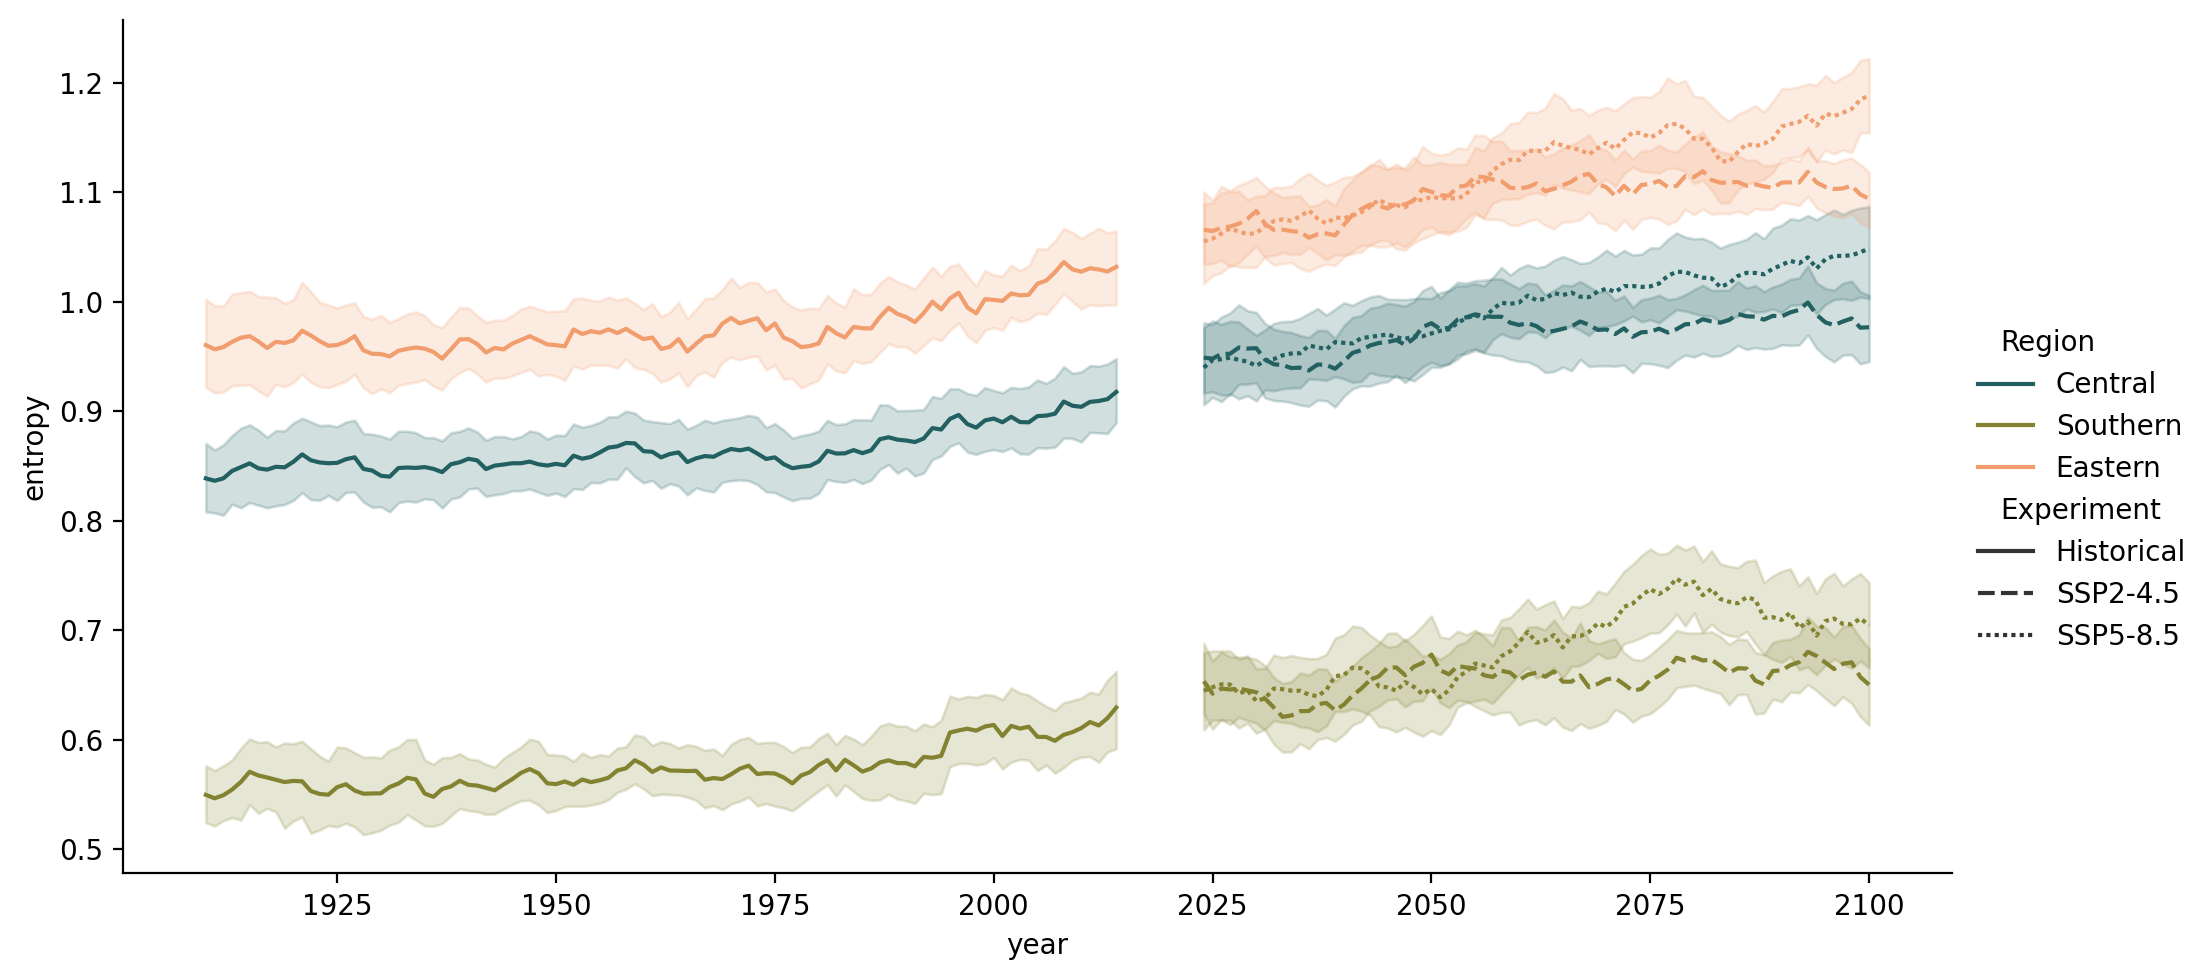

In [37]:
sns.relplot(data=df_ent,
            x="year", y="entropy", style='Experiment',
            kind="line", aspect=2, hue='Region', palette=palette, errorbar=('ci', 60))
#

Text(38.184416666666664, 0.5, 'Mean Anual Preciptation (mm/year)')

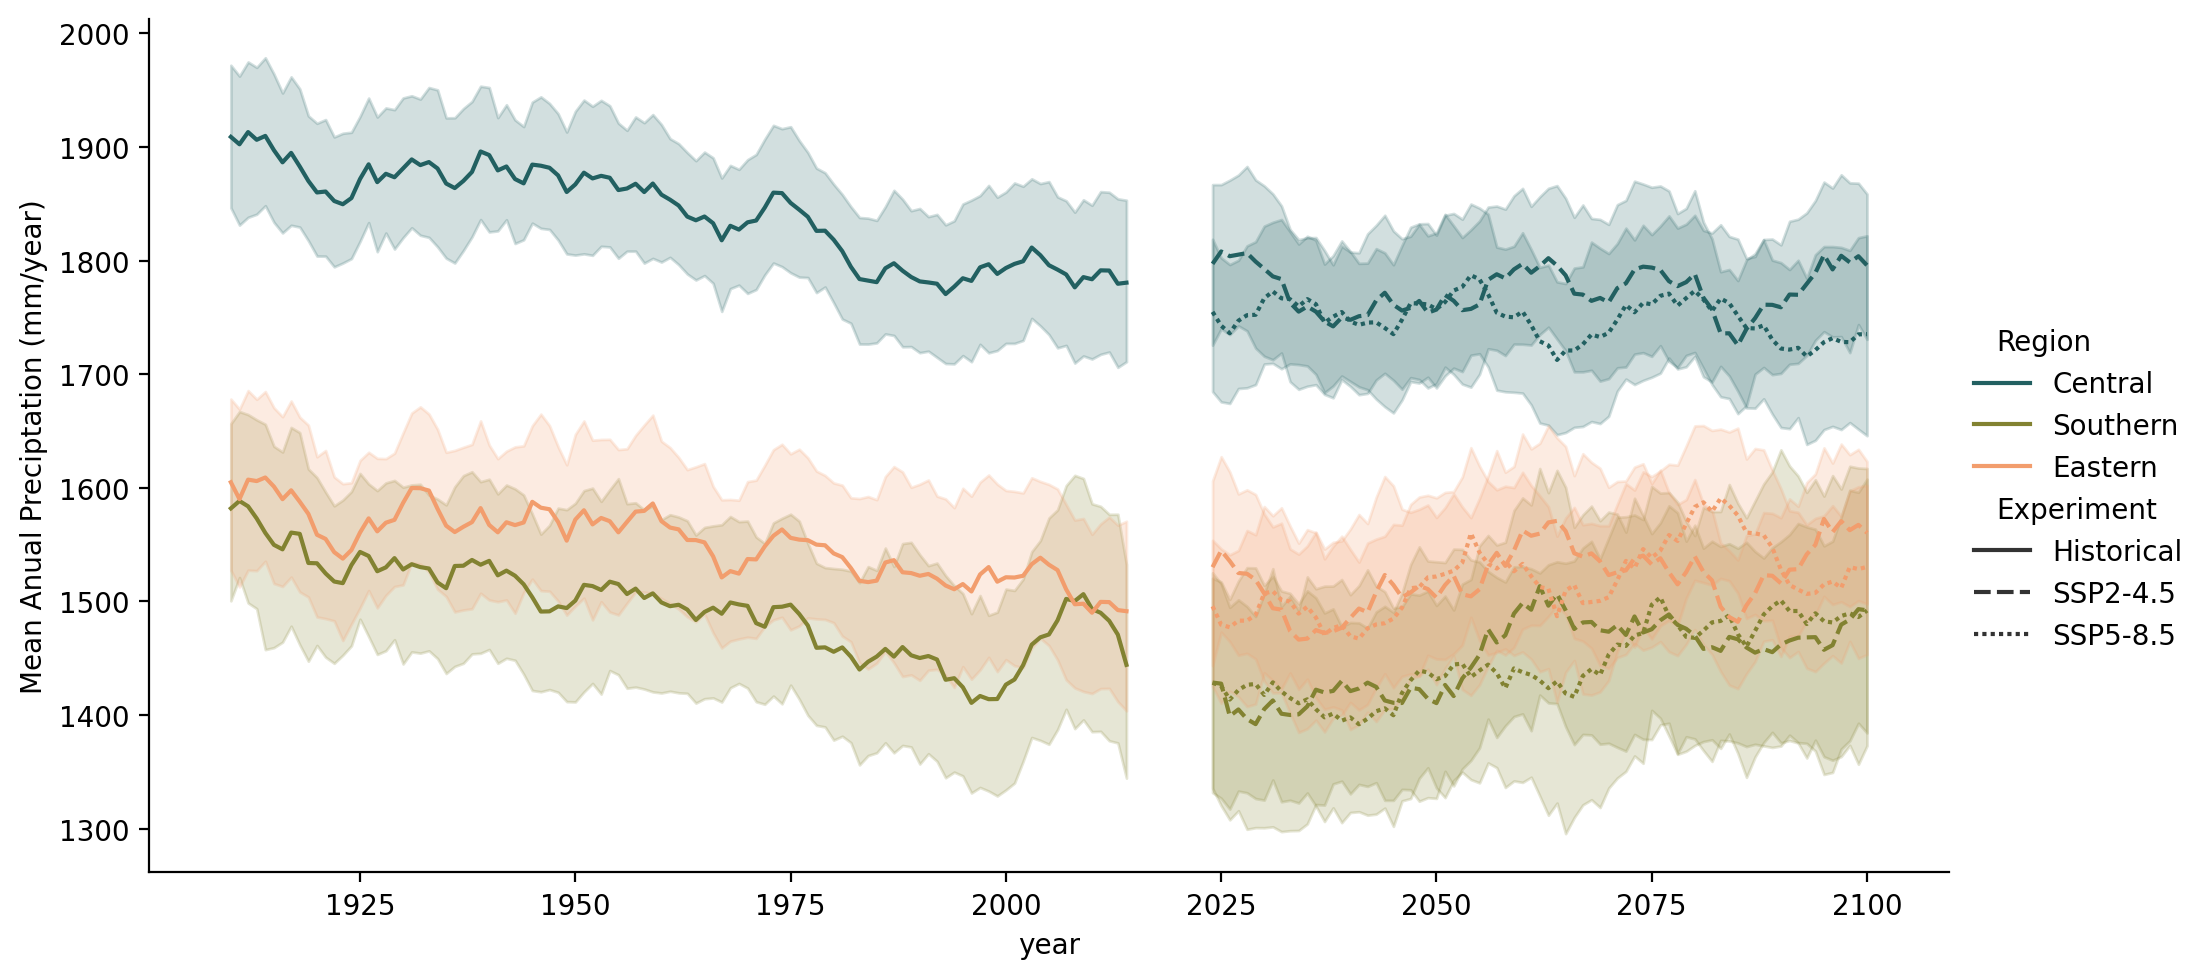

In [38]:
#climatology in historical 
#clim_big_ds = big_ds.sel(experiment_id='historical').sel(year=slice(1981, 2010)).mean(dim='year')
#anom_ds = big_ds - clim_big_ds
sns.relplot(data=df_pr,
            x="year", y="pr", style='Experiment',
            kind="line", aspect=2, hue='Region', palette=palette, errorbar=('ci', 60))
#
plt.ylabel('Mean Anual Preciptation (mm/year)')

## bests models

In [31]:
best = ['ACCESS-CM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4','MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']

In [32]:
df_pr_best = df_pr[df_pr.source_id.isin(best)]
#now for entropy
df_ent_best = df_ent[df_ent.source_id.isin(best)]

Text(38.184416666666664, 0.5, 'Mean Anual Preciptation (mm/year)')

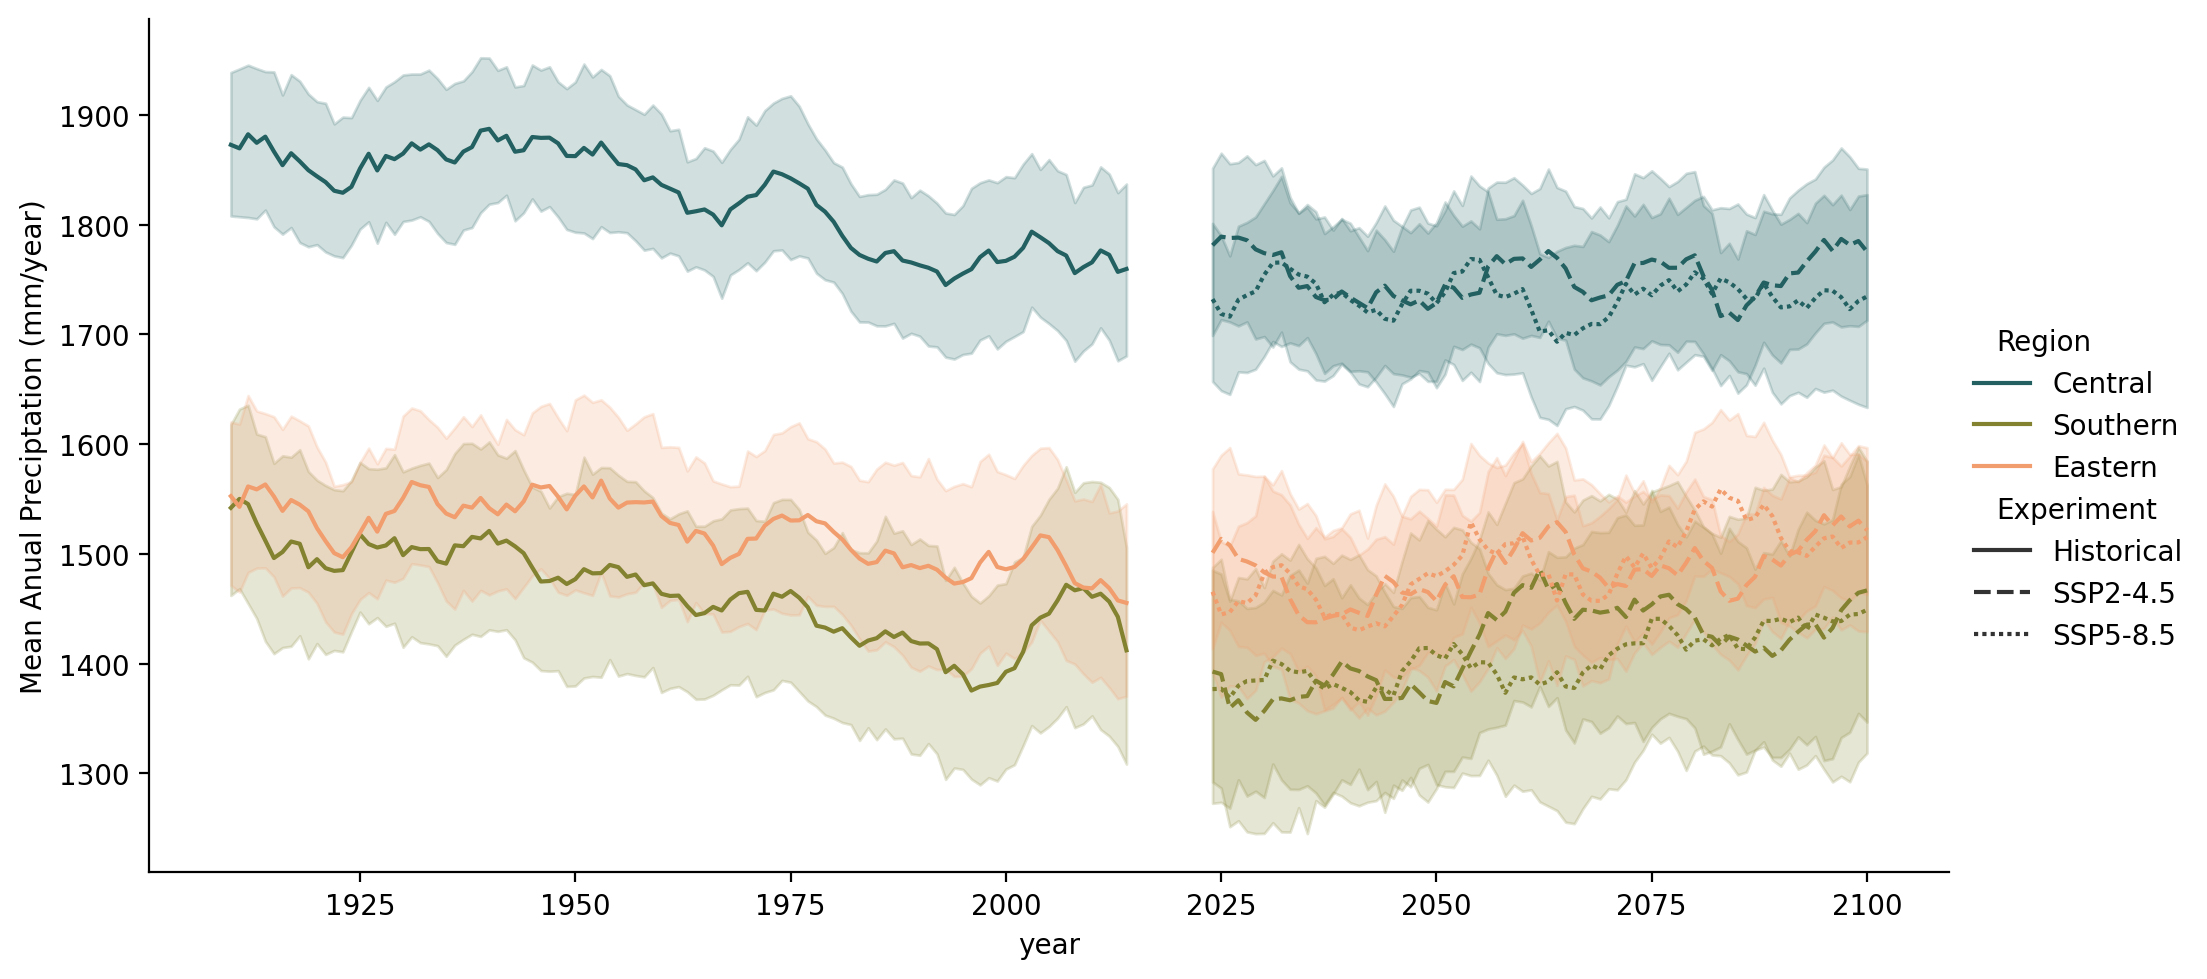

In [33]:
sns.relplot(data=df_pr_best,
            x="year", y="pr", style='Experiment',
            kind="line", aspect=2, hue='Region', palette=palette, errorbar=('ci', 60))
#
plt.ylabel('Mean Anual Preciptation (mm/year)')

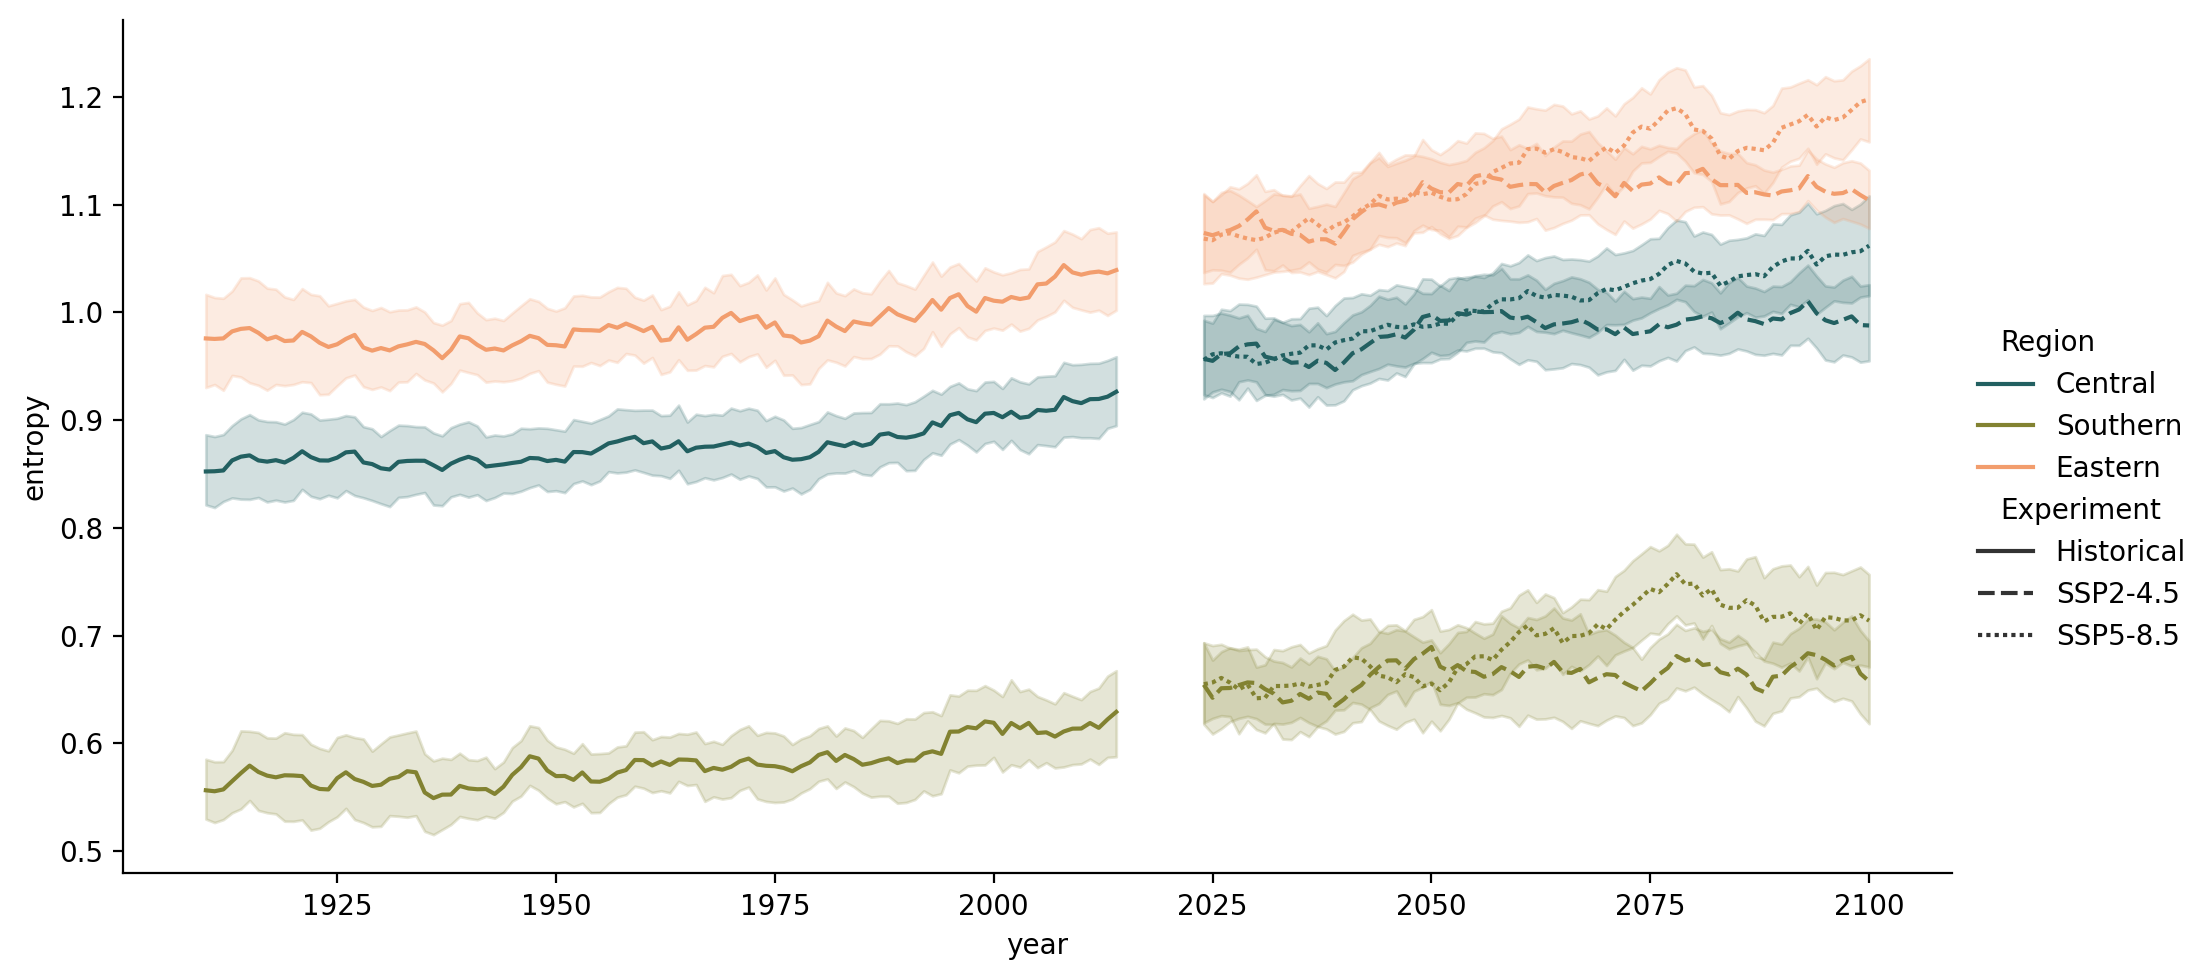

In [34]:
sns.relplot(data=df_ent_best,
            x="year", y="entropy", style='Experiment',
            kind="line", aspect=2, hue='Region', palette=palette, errorbar=('ci', 60))
#